# Detecting Emergent Patterns in Simulated Animals

## Introduction

Emergent behaviors are complex patterns that arise from the interactions of multiple agents, such as flocking in birds or swarming in insects, without centralized control. 
Understanding these behaviors is crucial in fields like robotics, wildlife monitoring, and crowd management. 
In this project, we simulate collective behaviors using the Couzin model and apply logistic regression, decision tree, random forest and XGBoost to detect and predict emergent patterns. 
By leveraging physical features such as momenta and directionality statistics, we aim to recognize and predict emergent behaviors in animal flocks using different
levels of available information and understand the underlying mechanism.

The goal of the project is to detect the formation of collective behaviors with animal simulators.

## Data preparation

We used the Couzin model to simulate emergent behaviors in animal groups, categorizing the final patterns into four types: (A) swarm, (B) torus, (C) parallel, and (D) undetectable. The dataset was divided into 70% for training and 30% for validation.

The simulations involved 50 fish, with varying parameters such as animal speed, maximum turning rate, size of the repulsion zone, and size of the orientation zone, while keeping the total vision distance constant. Each trajectory consisted of 4,000 time steps, with a time increment of 0.1 seconds. A total of 1,000 unique conditions were simulated.

The simulation code is available in the couzinswarm directory. Below is an example demonstrating the torus behavior.

![SegmentLocal](animation.gif "segment")

## Multi-class classification problem

Our aim is to classify the final phase of the system based on varying levels of input information:

(a) Simulation condition (dimension: 4).

(b) A snapshot during the formation  (t = 50 second) of the pattern (dimension: 300).

(c) Two subsequent snapshots from the early stages of pattern formation ($t_1$ = 5 and $t_2$ = 10) (dimension: 300).

*The raw dimension of (b) is 50 (fishes) $\times$ (3+3) (position and directionality in 3 dimensional box) = 300.
And the raw dimension of (c) is 300 as well, 50 (fishes) $\times$ (3+3) (position at $t_1$ and $t_2$) = 300, where $t_1$ and $t_2$ are the two subsequent times (separated from 5 seconds).


## Featurization 

Due to the high dimensionality nature, we used PCA analysis to reduce the dimensionality of (b) and (c) as shown below



Number of folders: 1000
Explained variance ratio: [0.23707788 0.21046987 0.20651213 0.01702209 0.01539516 0.01414898
 0.00468969 0.00438767 0.00399815 0.0038365 ]
Explained variance ratio: [0.23707788 0.21046987 0.20651213]
Explained variance ratio: [0.10300625 0.09363302 0.08956162 0.01042746 0.00929654 0.00890788
 0.00860254 0.00806272 0.00781928 0.00773839]
Explained variance ratio: [0.10300625 0.09363302 0.08956162]


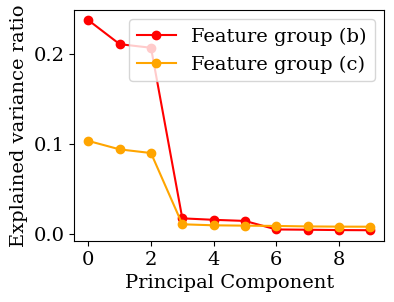

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import json
import os

sys.path.append("/home/ggu7596/ML_collective_behaviors/post_analysis/analysis_classes")
try:
    from post_process_methods import post_process_methods
except ImportError as e:
    print(f"ImportError: {e}")
directory_path = '/home/ggu7596/ML_collective_behaviors/simulation_setup/data_collections/4D_scan_data/high_dim_data_v2'
traj_name = "early_snapshot_1.txt"
trend_name = "trend_snapshot_1.txt"
PP = post_process_methods(directory_path,1)
PP.collect_simulation_paras()
collected_data_1 = PP.collect_high_dim_data(traj_name)
collected_data_2 = PP.collect_high_dim_data(trend_name)
_,explained_variance = PP.PCA_analysis(collected_data_1, n_components = 10)
fig,ax = plt.subplots(figsize = (4,3))
plt.rcParams.update({'font.size':14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']  # Or another serif font available
plt.rcParams['mathtext.fontset'] = 'cm'
plt.plot(explained_variance,"o-",color = "red",label = "Feature group (b)")
plt.xlabel("Principal Component")
plt.ylabel("Explained variance ratio")
principal_components_1,_ = PP.PCA_analysis(collected_data_1, n_components = 3)
_,explained_variance = PP.PCA_analysis(collected_data_2, n_components = 10)
plt.plot(explained_variance,"o-",label = "Feature group (c)",color = "orange")
plt.xlabel("Principal Component")
plt.ylabel("Explained variance ratio")
principal_components_2,_ = PP.PCA_analysis(collected_data_2, n_components = 3)
plt.legend()


Both (b) and (c) possess three dominant principal components based on the variance ratio, where group (b) has smaller variance.

We kept 3 principals for both features in the following analysis. 


## Method

We used four classification methods to test three different feature groups, which are

(a) Logistic regression
 
(b) Decision tree
 
(c) Random forest
 
(d) XGBoost

(b) (c) and (d) are all tree based methods. To avoid overfitting, we use a maximum tree depth at 4.

## Results

### Convergence of methods

To explore the convergence of methods, we plotted the number of iterations for logistic regression, modeled random forest tree and XGBoost for different number of estimators.

Text(0, 0.5, 'Cross entropy')

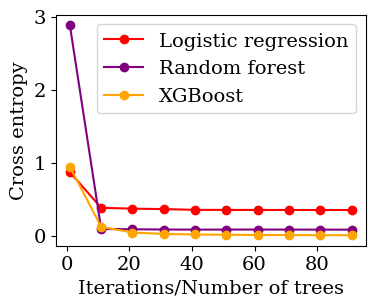

In [12]:
import numpy as np
import json
import matplotlib.pyplot as plt
path = "/home/ggu7596/ML_collective_behaviors/simulation_setup/data_collections/4D_scan_data/high_dim_data_v2"
filename = 'loss_track.json'
dictionary = json.load(open(path+"/"+filename))
LR_loss = dictionary['LR']
RF_loss = dictionary['RF']
XGB_loss = dictionary['XGB']
steps = np.arange(1,101,10)
colors = ["red","purple","orange"]
fig,ax = plt.subplots(figsize = (4,3))
plt.rcParams.update({'font.size':14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']  # Or another serif font available
plt.rcParams['mathtext.fontset'] = 'cm'
plt.plot(steps,LR_loss,'o-',label = "Logistic regression",color = colors[0])
plt.plot(steps,RF_loss,'o-',label = "Random forest",color = colors[1])
plt.plot(steps,XGB_loss,'o-',label = "XGBoost",color = colors[2])
plt.legend()
plt.xlabel("Iterations/Number of trees")
plt.ylabel("Cross entropy")

The results show that all methods have good convergence and we use number of trees for 20 in the following modeling to avoid overfitting as well.

In [14]:
path = "/home/ggu7596/ML_collective_behaviors/simulation_setup/data_collections/4D_scan_data/high_dim_data_v2"
simulation_input = "ML_performance.json"
snapshot_input = "ML_performance_PCA.json"
early_trend_input = "ML_performance_early_trends.json"
dictionary_simulation = json.load(open(path+"/"+simulation_input))
snapshot= json.load(open(path+"/"+snapshot_input))
early_trend= json.load(open(path+"/"+early_trend_input))

### Confusion matrix

In [15]:
import pandas as pd
dictionary = dictionary_simulation
ML_methods = dictionary['ML method']
for i,ML_method in enumerate(ML_methods):
    confusion_matrix_train = dictionary['confusion train'][i]
    df = pd.DataFrame(confusion_matrix_train)
    df.index = ['Swarm',"Torus","Parallel","N/A"]
    df.columns = ['Swarm',"Torus","Parallel","N/A"]
    table  = df.style.set_caption("Confusion matrix of training set: "+ML_method)
    display(table)

,Swarm,Torus,Parallel,N/A
Swarm,150,12,14,1
Torus,17,62,23,0
Parallel,13,8,370,3
N/A,2,4,4,17


,Swarm,Torus,Parallel,N/A
Swarm,149,15,9,4
Torus,4,68,28,2
Parallel,3,13,375,3
N/A,0,6,14,7


,Swarm,Torus,Parallel,N/A
Swarm,158,5,14,0
Torus,9,63,30,0
Parallel,6,7,381,0
N/A,5,6,15,1


,Swarm,Torus,Parallel,N/A
Swarm,169,4,4,0
Torus,4,90,8,0
Parallel,3,5,385,1
N/A,0,1,3,23


The confusion matrix gives a detailed true and false classification results, reading the statistics is not straightfoward.

We further use macro precision and weighted precision to decribe the results.


### Macro and weighted precision

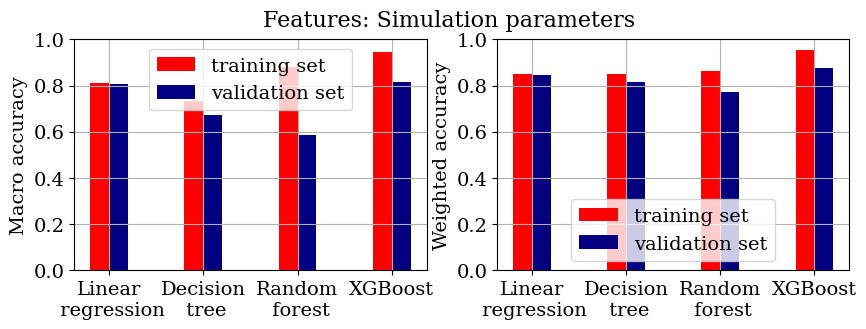

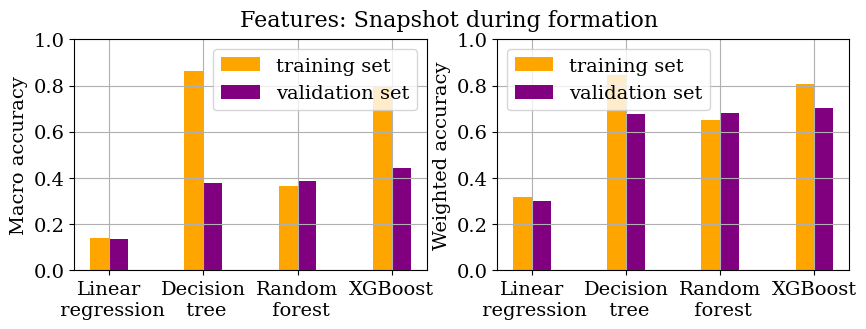

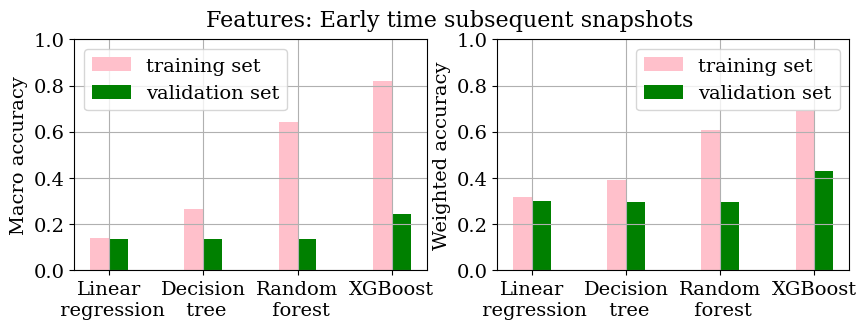

In [16]:
# Bar plot
def plot_performance(dict,Features,color1,color2):
    plt.rcParams.update({'font.size':14})
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['DejaVu Serif']  # Or another serif font available
    plt.rcParams['mathtext.fontset'] = 'cm'
    xticks = ["Linear\n regression","Decision\n tree","Random\n forest","XGBoost"]
    dictionary = dict
    ML_methods = dictionary['ML method']
    training_macro_acc = np.array(dictionary['training macro acc'])
    validation_macro_acc = np.array(dictionary['validation macro acc'])
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))  # 1 row, 2 columns
    ax[0].bar(np.arange(len(ML_methods))-0.1,training_macro_acc,width=0.2,color = color1,label = "training set")
    ax[0].bar(np.arange(len(ML_methods))+0.1,validation_macro_acc,width=0.2,color = color2,label = "validation set")
    ax[0].set_xticks(np.arange(len(ML_methods)),xticks);
    ax[0].set_ylim(0,1)
    ax[0].set_ylabel("Macro accuracy")
    ax[0].legend()
    ax[0].grid(True)

    training_weighted_acc = np.array(dictionary['training weighted acc'])
    validation_weighted_acc = np.array(dictionary['validation weighted acc'])
    plt.bar(np.arange(len(ML_methods))-0.1,training_weighted_acc,width=0.2,color = color1,label = "training set")
    plt.bar(np.arange(len(ML_methods))+0.1,validation_weighted_acc,width=0.2,color = color2,label = "validation set")
    plt.xticks(np.arange(len(ML_methods)),xticks);
    plt.ylim(0,1)
    plt.ylabel("Weighted accuracy")
    plt.legend()
    plt.grid(True)
    fig.suptitle("Features: "+str(Features), fontsize=16)
    plt.show()
plot_performance(dictionary_simulation,"Simulation parameters","red","navy")
plot_performance(snapshot,"Snapshot during formation","orange","purple")
plot_performance(early_trend,"Early time subsequent snapshots","pink","green")

We observed that the macro precision $\frac{1}{N}\sum\limits_{i}^N\mathrm{Precision}_i$ are always lower than the weighted precision $\sum\limits_{i}^N\omega_i\mathrm{Precision}_i$, where $\omega_i$ is the weight for class $i$ and is determined by the ratio of samples in that class.

This is due to the fact that the number of samples in torus and no-group-formed are much fewer than the two other classes. Therefore, it is more appropriate to use weighted precision to describe the results.

Among all the methods, XGBoost performs the best in the three different sceniors. 

Using simulation parameters as features lead to robust performance for all machine learning models, because they are the underlying physics already.

As the features become more complicated and contain less and less information about the formation of the collective pattern, the performance becomes worse and worse.

Using a snapshot that might already be seen early-stage of formations is better than using short trajectories in the initial formation.

Feature group (b) outperforms (c) can also be inferred from the PCA analysis, where (c) has smaller variance for the most dominant component. Therefore, keeping three major components might truncate out more information.


### Interpretability of model
Using simple models like logistic regression or decision tree combined with simple features can give interpretable results as shown below,

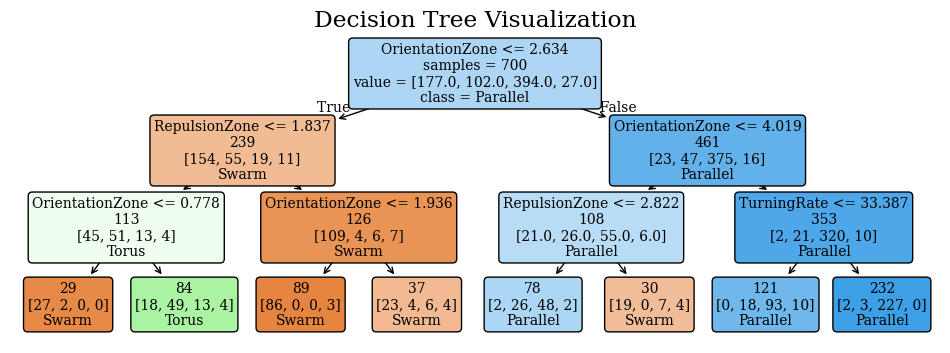

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree,export_text
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("/home/ggu7596/ML_collective_behaviors/post_analysis/analysis_classes")
try:
    from ML_methods import Basic_classification_methods
except ImportError as e:
    print(f"ImportError: {e}")
test_size = 300
train_size = 700
divider = 8
directory_path = '/home/ggu7596/ML_collective_behaviors/simulation_setup/data_collections/4D_scan_data/high_dim_data_v2'
filename = 'labels.txt'
method = Basic_classification_methods(directory_path,filename)
method.load_data(divider)
method.input_data = method.data[:,:4]
y_train, y_train_pred, y_test, y_test_pred, tree_model,simulation_time = method.perform_decision_tree(method.input_data,method.output_data,train_size,test_size,max_depth = 3)
feature_means = method.scaler.mean_
feature_stds = np.sqrt(method.scaler.var_)

# Function to denormalize thresholds
def denormalize_threshold(value, feature_index):
    return value * feature_stds[feature_index] + feature_means[feature_index]
def denormalize_thresholds(tree, feature_means, feature_stds):
    """Update tree thresholds to reflect original feature values."""
    tree_thresholds = tree.tree_.threshold
    feature_indices = tree.tree_.feature

    for i in range(len(tree_thresholds)):
        if feature_indices[i] != -2:  # -2 indicates a leaf node
            feature_index = feature_indices[i]
            tree_thresholds[i] = tree_thresholds[i] * feature_stds[feature_index] + feature_means[feature_index]

# Denormalize thresholds in the decision tree
denormalize_thresholds(tree_model, feature_means, feature_stds)
# Visualize the decision tree

feature_names = ["Speed", "TurningRate", "RepulsionZone","OrientationZone"]
class_names = ["Swarm", "Torus","Parallel","N/A"]

plt.figure(figsize=(12, 4))
plot_tree(
    tree_model,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    impurity = False,
    label='root',
    fontsize=10 # Set font size here
)
plt.title("Decision Tree Visualization")
#plt.savefig("/home/ggu7596/ML_collective_behaviors/post_analysis/Plots/decision_tree.pdf",format='pdf')
plt.show()

The tree indicates that when the orientation zone is large enough, the formation of the pattern will mostly be parallel. This is intuitive, since when the orientation zone is big enough the fishes would like to mimics neighbors directionality and form a parallel pattern in the end.
Only when repulsion zone and orientation zone has a proper relation, the torus pattern can be found, otherwise swarm behaviors.
The turning rate and speed are much less important than the sizes of repulsion and orientation.

## Conclusion

We used four machine learning models (logistic regression, decision tree, random forest and XGBoost) to model the collective behaviors of school of fishes.

Our results show that the samples have strong imbalance, since the number of samples in torus and no-pattern-found are much fewer than swarm and parallel behaviors.

For simple features, the models are very robust, and we used decision tree to interpret the results.

For high dimensional features, PCA were used to first reduce the dimensionality and fit models. The snapshot at early stage provided valuable on detecting the formation of the final pattern.